In [1]:
%load_ext autoreload
%autoreload 2

from run_models import load_model
from plot_utils import *
from DisruptionPredictors import DisruptionPredictorSM, DisruptionPredictorRF, DisruptionPredictorTinguely

from evaluate_performance import benchmark_au_roc, benchmark_true_detection

horizons = np.linspace(0.001, 0.5, 11)

device = 'cmod'
dataset = 'random100'
numeric_feats = ['ip','Wmhd','n_e','kappa','li']

#device = 'synthetic'
#dataset = 'synthetic100'
#numeric_feats = ['ip', 'n_e', 'aminor', 'kappa', 'squareness', 'delta', 'li', 'Wmhd']


In [2]:
# Load models and create disruption predictors

cph_model, cph_transformer = load_model('cph', device, dataset)
cph_predictor = DisruptionPredictorSM("Cox Proportional Hazards", cph_model, numeric_feats, cph_transformer)

dcph_model, dcph_transformer = load_model('dcph', device, dataset)
dcph_predictor = DisruptionPredictorSM("Deep Cox Proportional Hazards", dcph_model, numeric_feats, dcph_transformer)

dsm_model, dsm_transformer = load_model('dsm', device, dataset)
dsm_predictor = DisruptionPredictorSM("Deep Survival Machines", dsm_model, numeric_feats, dsm_transformer)

dcm_model, dcm_transformer = load_model('dcm', device, dataset)
dcm_predictor = DisruptionPredictorSM("Deep Cox Mixture", dcm_model, numeric_feats, dcm_transformer)

rsf_model, rsf_transformer = load_model('rsf', device, dataset)
rsf_predictor = DisruptionPredictorSM("Random Survival Forest", rsf_model, numeric_feats, rsf_transformer)

rf_model, rf_transformer = load_model('rf', device, dataset)
rf_predictor = DisruptionPredictorRF("Random Forest", rf_model, numeric_feats, rf_transformer)

ting_model, ting_transformer = load_model('rf', device, dataset)
ting_predictor = DisruptionPredictorTinguely("Tinguely et al. 2019", ting_model, numeric_feats, ting_transformer)



Loaded model from models/cph_cmod_random100.pkl
Loaded model from models/dcph_cmod_random100.pkl
Loaded model from models/dsm_cmod_random100.pkl
Loaded model from models/dcm_cmod_random100.pkl
Loaded model from models/rsf_cmod_random100.pkl
Loaded model from models/rf_cmod_random100.pkl
Loaded model from models/rf_cmod_random100.pkl


In [10]:
au_rocs_cph = benchmark_au_roc(cph_predictor, horizons, device, dataset+'_test')
au_rocs_dcph = benchmark_au_roc(dcph_predictor, horizons, device, dataset+'_test')
au_rocs_dcm = benchmark_au_roc(dcm_predictor, horizons, device, dataset+'_test')
au_rocs_dsm = benchmark_au_roc(dsm_predictor, horizons, device, dataset+'_test')
au_rocs_rsf = benchmark_au_roc(rsf_predictor, horizons, device, dataset+'_test')
au_rocs_rf = benchmark_au_roc(rf_predictor, horizons, device, dataset+'_test')
au_rocs_ting = benchmark_au_roc(ting_predictor, horizons, device, dataset+'_test')

print(au_rocs_cph)
print(au_rocs_dcph)
print(au_rocs_dcm)
print(au_rocs_dsm)
print(au_rocs_rsf)
print(au_rocs_rf)
print(au_rocs_ting)

[0.12637362637362637, 0.09340659340659341, 0.18131868131868129, 0.32417582417582413, 0.3571428571428571, 0.32967032967032966, 0.34065934065934067, 0.34065934065934067, 0.34615384615384615, 0.3516483516483516, 0.3406593406593406]
[0.5934065934065934, 0.44505494505494503, 0.3571428571428571, 0.36813186813186816, 0.33516483516483514, 0.34065934065934067, 0.34615384615384615, 0.34615384615384615, 0.2637362637362637, 0.24725274725274726, 0.2637362637362637]
[0.8241758241758241, 0.2857142857142857, 0.24175824175824173, 0.20879120879120877, 0.12637362637362637, 0.06593406593406592, 0.06593406593406592, 0.1593406593406593, 0.10439560439560436, 0.12087912087912085, 0.14835164835164832]
[0.6428571428571428, 0.41758241758241754, 0.30769230769230765, 0.3021978021978022, 0.20329670329670324, 0.15934065934065933, 0.15934065934065933, 0.15934065934065933, 0.21978021978021972, 0.21978021978021972, 0.22527472527472525]
[0.6263736263736264, 0.32967032967032966, 0.3131868131868132, 0.32967032967032966, 0

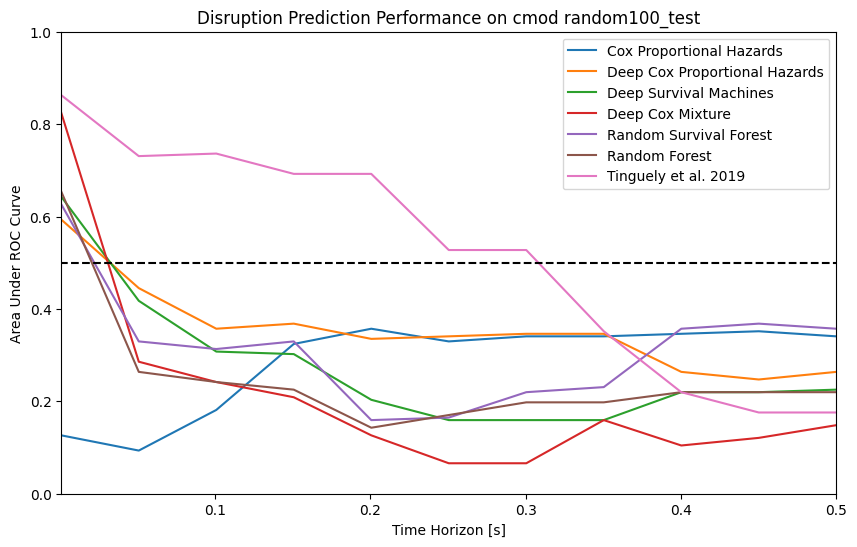

In [6]:
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(horizons, au_rocs_cph, label='Cox Proportional Hazards')
plt.plot(horizons, au_rocs_dcph, label='Deep Cox Proportional Hazards')
plt.plot(horizons, au_rocs_dsm, label='Deep Survival Machines')
plt.plot(horizons, au_rocs_dcm, label='Deep Cox Mixture')
plt.plot(horizons, au_rocs_rsf, label='Random Survival Forest')
plt.plot(horizons, au_rocs_rf, label='Random Forest')
plt.plot(horizons, au_rocs_ting, label='Tinguely et al. 2019')

# Plot horizontal line at y = 0.5 for reference to 'random guessing'
plt.plot([0, 1], [0.5, 0.5], linestyle='--', color='black')

plt.xlim([min(horizons), max(horizons)])
plt.ylim([0, 1.0])

plt.xlabel('Time Horizon [s]')
plt.ylabel('Area Under ROC Curve')
plt.title('Disruption Prediction Performance on '+device+' '+dataset+'_test')

plt.legend()
plt.show()



In [12]:
horizon = 0.2
amoc_cph = benchmark_true_detection(cph_predictor, horizon, device, dataset+'_test')
amoc_dcph = benchmark_true_detection(dcph_predictor, horizon, device, dataset+'_test')
amoc_dcm = benchmark_true_detection(dcm_predictor, horizon, device, dataset+'_test')
amoc_dsm = benchmark_true_detection(dsm_predictor, horizon, device, dataset+'_test')
amoc_rsf = benchmark_true_detection(rsf_predictor, horizon, device, dataset+'_test')
amoc_rf = benchmark_true_detection(rf_predictor, horizon, device, dataset+'_test')
amoc_ting = benchmark_true_detection(ting_predictor, horizon, device, dataset+'_test')


c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.ve

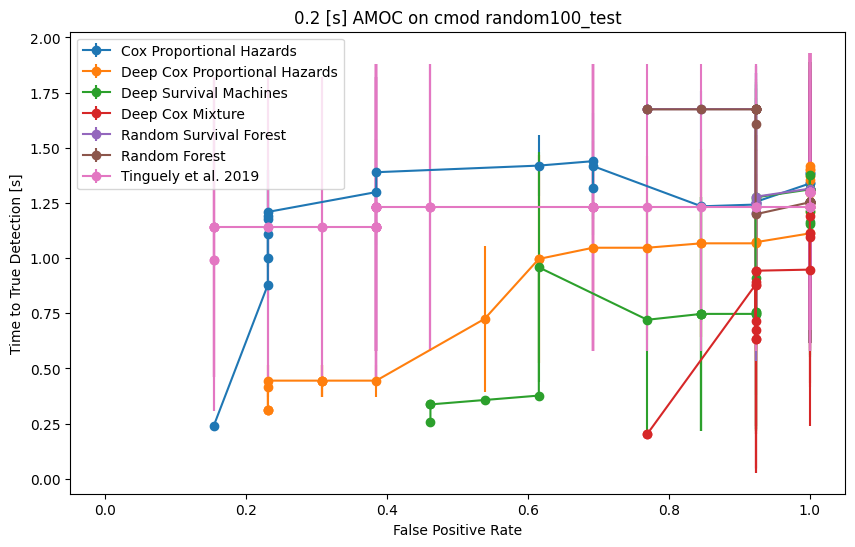

In [13]:
plt.figure(figsize=(10, 6))
plt.errorbar(amoc_cph[0], amoc_cph[1], yerr=amoc_cph[2], label='Cox Proportional Hazards', fmt='o-')
plt.errorbar(amoc_dcph[0], amoc_dcph[1], yerr=amoc_dcph[2], label='Deep Cox Proportional Hazards', fmt='o-')
plt.errorbar(amoc_dsm[0], amoc_dsm[1], yerr=amoc_dsm[2], label='Deep Survival Machines', fmt='o-')
plt.errorbar(amoc_dcm[0], amoc_dcm[1], yerr=amoc_dcm[2], label='Deep Cox Mixture', fmt='o-')
plt.errorbar(amoc_rsf[0], amoc_rsf[1], yerr=amoc_rsf[2], label='Random Survival Forest', fmt='o-')
plt.errorbar(amoc_rf[0], amoc_rf[1], yerr=amoc_rf[2], label='Random Forest', fmt='o-')
plt.errorbar(amoc_ting[0], amoc_ting[1], yerr=amoc_ting[2], label='Tinguely et al. 2019', fmt='o-')

#plt.xlim([min(horizons), max(horizons)])
#plt.ylim([0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('Time to True Detection [s]')
plt.title(f'{horizon} [s] AMOC on {device} {dataset}_test')

plt.legend()
plt.show()